# Using Convolutional neural networks to classify Sign language digits-KERAS

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!free -g


              total        used        free      shared  buff/cache   available
Mem:             12           1           1           0          10          11
Swap:             0           0           0


In [1]:
%cd drive/projects/Sign Language

/content/drive/projects/Sign Language


In [2]:
%ls

backgroud_ds/             gen_texture_ds.py     Sign Language digits.ipynb
background_datagen.ipynb  hand_detect.py        Visualizations/
Dataset/                  __pycache__/
Dataset_Aug/              SignLanguage_90_S.h5


In [0]:
%matplotlib inline

from keras.preprocessing import image # Image processing 
import numpy as np # Numpy array manipulation
import os,shutil # Creating and copying directories
import matplotlib.pyplot as plt # Visualization

In [0]:
ogi_dir = 'Dataset' # Source directory
ds_aug_dir = "Dataset_Aug" # Augmented ds with background variation

In [0]:
# Change dir to pwd 
if not os.path.exists(ds_aug_dir):
  os.mkdir(ds_aug_dir)

In [0]:
# Create 3 directories (train ,test, validation) for ImageDataGenerator
train_dir = os.path.join(ds_aug_dir,'train')
test_dir = os.path.join(ds_aug_dir,'test')
validation_dir = os.path.join(ds_aug_dir,'validation')

def create_split(ogi_dir):
    if not os.path.exists(train_dir):
        os.mkdir(train_dir)
    if not os.path.exists(test_dir):
        os.mkdir(test_dir)
    if not os.path.exists(validation_dir):
        os.mkdir(validation_dir)
create_split(ds_aug_dir)

In [0]:
# Create classes (10) directories
def make_classes(train_dir, test_dir, validation_dir):
    for i in range(10):
        train_labels_dir = os.path.join(train_dir,str(i))
        if not os.path.exists(train_labels_dir):
            os.mkdir(train_labels_dir)
        test_labels_dir = os.path.join(test_dir,str(i))
        if not os.path.exists(test_labels_dir):
            os.mkdir(test_labels_dir)
        validation_labels_dir = os.path.join(validation_dir,str(i))
        if not os.path.exists(validation_labels_dir):
            os.mkdir(validation_labels_dir)
make_classes(train_dir, test_dir, validation_dir)

In [0]:
# --Deprecated--
train_size = 150
def copy_data(ogi_dir, train_dir, test_dir, validation_dir):
    for i in range(10):
        src = os.path.join(ogi_dir,str(i))
        for f in os.listdir(src)[:train_size]:
            dest = os.path.join(train_dir,str(i))
            f_path = os.path.join(src,f)
            shutil.copy(f_path, dest)
        for f in os.listdir(src)[train_size:train_size+50]:
            dest = os.path.join(validation_dir,str(i))
            f_path = os.path.join(src,f)
            shutil.copy(f_path, dest)
        for f in os.listdir(src)[train_size+50:]:
            dest = os.path.join(test_dir,str(i))
            f_path = os.path.join(src,f)
            shutil.copy(f_path, dest)

In [0]:
# Generate new Dataset

In [0]:
from hand_detect import ImageGen

In [7]:
b_path = "backgroud_ds"
background_imgs = []
for imgs in os.listdir(b_path):
    if not imgs.startswith('.'):
        path = os.path.join(b_path, imgs)
        background_imgs.append(path)
print("Length of background images %d"%len(background_imgs))

Length of background images 986


In [0]:
def get_image_dict(path):
  image_dict = dict()

  for dirs in os.listdir(path):
    if not(dirs.startswith('.')):
      dir_path = os.path.join(path, dirs)
      for n_dirs in os.listdir(dir_path):
        if not(n_dirs.startswith('.')):
          temp_path = os.path.join(dir_path, n_dirs)
          for image in os.listdir(temp_path):
            if not(image.startswith('.')):
              if (n_dirs) in image_dict:
                image_dict[n_dirs].append(os.path.join(temp_path,image))
              else:
                image_dict[n_dirs] = [os.path.join(temp_path,image)]
  return image_dict

hs_dict = get_image_dict(ogi_dir)

In [9]:
len(hs_dict['0'])

205

In [28]:
size = 200
def gen_ds(final_ds_path):
  #   --Train, Test, Val--
  for di in os.listdir(final_ds_path):
    if not di.startswith('.'):
      path_dir = os.path.join(final_ds_path, di)
  #   --Classes 0 -9--
      for num_dir in os.listdir(path_dir):
         if not di.startswith('.'):
            f_path = os.path.join(path_dir, num_dir)
            print(f_path)
            if len(os.listdir(f_path)) ==size:
              print("occured")
              continue
            imgen = ImageGen(hs_dict[num_dir], background_imgs, size, f_path)
            imgen.get_images()
          
     
gen_ds(ds_aug_dir)

Dataset_Aug/validation/9
occured
Dataset_Aug/validation/8
occured
Dataset_Aug/validation/7


error: ignored

In [0]:
# Image Rescaling and preprocessing
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [100]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size =(100,100), batch_size=64, class_mode= 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size =(100,100), batch_size=16, class_mode= 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size =(100,100), batch_size=16, class_mode= 'categorical')

Found 1946 images belonging to 10 classes.
Found 1861 images belonging to 10 classes.
Found 1815 images belonging to 10 classes.


In [0]:
from keras import models,layers
from keras import optimizers
import keras

In [0]:
# Defining model
height = 100
width = 100
channels = 3
num_classes = 10

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.load_weights('SignLanguage_84_aug.h5')

model.compile(optimizer=optimizers.RMSprop(lr=1e-3),metrics=['acc'], loss='categorical_crossentropy')

In [0]:
callbacks_list= [
    keras.callbacks.ModelCheckpoint(
            filepath='SignLanguage_aug.h5',
            monitor='val_loss',
            save_best_only=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
           monitor='loss',
           factor=0.1,
           patience=5,
   )   
]

In [105]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks = callbacks_list
)

Epoch 1/50
100/100 [==============================] - 56s 557ms/step - loss: 0.5634 - acc: 0.8113 - val_loss: 0.6371 - val_acc: 0.8175
Epoch 2/50
100/100 [==============================] - 53s 528ms/step - loss: 0.4848 - acc: 0.8371 - val_loss: 0.6958 - val_acc: 0.7788
Epoch 3/50
100/100 [==============================] - 50s 500ms/step - loss: 0.4348 - acc: 0.8581 - val_loss: 0.5694 - val_acc: 0.8325
Epoch 4/50
 64/100 [==================>...........] - ETA: 15s - loss: 0.4356 - acc: 0.8567

100/100 [==============================] - 49s 486ms/step - loss: 0.4239 - acc: 0.8575 - val_loss: 0.5744 - val_acc: 0.8300
Epoch 5/50
100/100 [==============================] - 53s 530ms/step - loss: 0.3816 - acc: 0.8758 - val_loss: 0.5895 - val_acc: 0.8200
Epoch 6/50
100/100 [==============================] - 50s 505ms/step - loss: 0.3651 - acc: 0.8799 - val_loss: 0.5036 - val_acc: 0.8488
Epoch 7/50
 84/100 [========================>.....] - ETA: 8s - loss: 0.3415 - acc: 0.8853

100/100 [==============================] - 61s 611ms/step - loss: 0.3393 - acc: 0.8854 - val_loss: 0.5744 - val_acc: 0.8175
Epoch 8/50
100/100 [==============================] - 60s 601ms/step - loss: 0.3225 - acc: 0.8940 - val_loss: 0.6212 - val_acc: 0.8225
Epoch 9/50
100/100 [==============================] - 55s 547ms/step - loss: 0.3049 - acc: 0.9019 - val_loss: 0.4920 - val_acc: 0.8538
Epoch 10/50
 86/100 [========================>.....] - ETA: 5s - loss: 0.2761 - acc: 0.9083

100/100 [==============================] - 52s 516ms/step - loss: 0.2911 - acc: 0.9070 - val_loss: 0.4851 - val_acc: 0.8575
Epoch 11/50
100/100 [==============================] - 57s 566ms/step - loss: 0.2481 - acc: 0.9196 - val_loss: 0.5059 - val_acc: 0.8475
Epoch 12/50
100/100 [==============================] - 59s 590ms/step - loss: 0.2408 - acc: 0.9206 - val_loss: 0.5075 - val_acc: 0.8550
Epoch 13/50
 85/100 [========================>.....] - ETA: 7s - loss: 0.2496 - acc: 0.9180

100/100 [==============================] - 53s 534ms/step - loss: 0.2410 - acc: 0.9214 - val_loss: 0.5607 - val_acc: 0.8488
Epoch 14/50
100/100 [==============================] - 54s 535ms/step - loss: 0.2218 - acc: 0.9323 - val_loss: 0.5459 - val_acc: 0.8488
Epoch 15/50
100/100 [==============================] - 60s 599ms/step - loss: 0.1884 - acc: 0.9351 - val_loss: 0.7925 - val_acc: 0.7850
Epoch 16/50
 86/100 [========================>.....] - ETA: 7s - loss: 0.2151 - acc: 0.9274

100/100 [==============================] - 61s 606ms/step - loss: 0.2163 - acc: 0.9272 - val_loss: 0.5700 - val_acc: 0.8413
Epoch 17/50
100/100 [==============================] - 60s 604ms/step - loss: 0.1820 - acc: 0.9371 - val_loss: 0.5633 - val_acc: 0.8550
Epoch 18/50
100/100 [==============================] - 63s 631ms/step - loss: 0.1785 - acc: 0.9396 - val_loss: 0.6577 - val_acc: 0.8287
Epoch 19/50
 86/100 [========================>.....] - ETA: 6s - loss: 0.1759 - acc: 0.9412

100/100 [==============================] - 52s 522ms/step - loss: 0.1704 - acc: 0.9434 - val_loss: 0.5319 - val_acc: 0.8650
Epoch 20/50
100/100 [==============================] - 51s 507ms/step - loss: 0.1632 - acc: 0.9464 - val_loss: 0.5425 - val_acc: 0.8575
Epoch 21/50
100/100 [==============================] - 50s 501ms/step - loss: 0.1604 - acc: 0.9456 - val_loss: 0.5080 - val_acc: 0.8712
Epoch 22/50
 86/100 [========================>.....] - ETA: 6s - loss: 0.1443 - acc: 0.9542

100/100 [==============================] - 49s 487ms/step - loss: 0.1452 - acc: 0.9538 - val_loss: 0.5705 - val_acc: 0.8562
Epoch 23/50
100/100 [==============================] - 54s 540ms/step - loss: 0.1460 - acc: 0.9497 - val_loss: 0.5461 - val_acc: 0.8562
Epoch 24/50
100/100 [==============================] - 50s 498ms/step - loss: 0.1330 - acc: 0.9560 - val_loss: 0.5506 - val_acc: 0.8625
Epoch 25/50
 86/100 [========================>.....] - ETA: 5s - loss: 0.1337 - acc: 0.9593

100/100 [==============================] - 51s 506ms/step - loss: 0.1272 - acc: 0.9611 - val_loss: 0.5741 - val_acc: 0.8688
Epoch 26/50
100/100 [==============================] - 48s 479ms/step - loss: 0.1293 - acc: 0.9588 - val_loss: 0.4798 - val_acc: 0.8912
Epoch 27/50
100/100 [==============================] - 53s 526ms/step - loss: 0.1299 - acc: 0.9570 - val_loss: 0.6092 - val_acc: 0.8550
Epoch 28/50
 86/100 [========================>.....] - ETA: 5s - loss: 0.1212 - acc: 0.9589

100/100 [==============================] - 51s 513ms/step - loss: 0.1184 - acc: 0.9603 - val_loss: 0.6253 - val_acc: 0.8650
Epoch 29/50
100/100 [==============================] - 49s 494ms/step - loss: 0.1258 - acc: 0.9605 - val_loss: 0.6238 - val_acc: 0.8575
Epoch 30/50
100/100 [==============================] - 49s 493ms/step - loss: 0.1060 - acc: 0.9648 - val_loss: 0.5441 - val_acc: 0.8612
Epoch 31/50
 87/100 [=========================>....] - ETA: 6s - loss: 0.1230 - acc: 0.9607

100/100 [==============================] - 56s 562ms/step - loss: 0.1207 - acc: 0.9613 - val_loss: 0.5462 - val_acc: 0.8800
Epoch 32/50
100/100 [==============================] - 64s 642ms/step - loss: 0.1051 - acc: 0.9641 - val_loss: 0.6189 - val_acc: 0.8700
Epoch 33/50
100/100 [==============================] - 52s 517ms/step - loss: 0.1063 - acc: 0.9679 - val_loss: 0.5672 - val_acc: 0.8812
Epoch 34/50
 86/100 [========================>.....] - ETA: 6s - loss: 0.1012 - acc: 0.9655

100/100 [==============================] - 53s 529ms/step - loss: 0.1057 - acc: 0.9656 - val_loss: 0.4865 - val_acc: 0.8838
Epoch 35/50
100/100 [==============================] - 53s 526ms/step - loss: 0.0920 - acc: 0.9670 - val_loss: 0.5792 - val_acc: 0.8725
Epoch 36/50
100/100 [==============================] - 61s 611ms/step - loss: 0.0885 - acc: 0.9722 - val_loss: 0.5348 - val_acc: 0.8788
Epoch 37/50
 85/100 [========================>.....] - ETA: 6s - loss: 0.0795 - acc: 0.9709

100/100 [==============================] - 52s 517ms/step - loss: 0.0778 - acc: 0.9721 - val_loss: 0.6636 - val_acc: 0.8800
Epoch 38/50
100/100 [==============================] - 57s 566ms/step - loss: 0.0874 - acc: 0.9708 - val_loss: 0.5622 - val_acc: 0.8838
Epoch 39/50
100/100 [==============================] - 59s 590ms/step - loss: 0.0907 - acc: 0.9703 - val_loss: 0.6531 - val_acc: 0.8462
Epoch 40/50
 85/100 [========================>.....] - ETA: 7s - loss: 0.0825 - acc: 0.9710

100/100 [==============================] - 60s 596ms/step - loss: 0.0783 - acc: 0.9723 - val_loss: 0.5806 - val_acc: 0.8825
Epoch 41/50
100/100 [==============================] - 57s 573ms/step - loss: 0.0792 - acc: 0.9741 - val_loss: 0.5785 - val_acc: 0.8850
Epoch 42/50
100/100 [==============================] - 53s 532ms/step - loss: 0.0849 - acc: 0.9707 - val_loss: 0.5058 - val_acc: 0.8875
Epoch 43/50
 85/100 [========================>.....] - ETA: 6s - loss: 0.0390 - acc: 0.9869

100/100 [==============================] - 52s 521ms/step - loss: 0.0383 - acc: 0.9873 - val_loss: 0.5194 - val_acc: 0.8875
Epoch 44/50
100/100 [==============================] - 50s 503ms/step - loss: 0.0252 - acc: 0.9924 - val_loss: 0.5730 - val_acc: 0.8912
Epoch 45/50
100/100 [==============================] - 56s 555ms/step - loss: 0.0297 - acc: 0.9916 - val_loss: 0.5731 - val_acc: 0.8888
Epoch 46/50
 86/100 [========================>.....] - ETA: 6s - loss: 0.0336 - acc: 0.9910

100/100 [==============================] - 53s 527ms/step - loss: 0.0333 - acc: 0.9910 - val_loss: 0.5518 - val_acc: 0.8925
Epoch 47/50
100/100 [==============================] - 51s 505ms/step - loss: 0.0316 - acc: 0.9898 - val_loss: 0.5344 - val_acc: 0.8912
Epoch 48/50
100/100 [==============================] - 51s 509ms/step - loss: 0.0234 - acc: 0.9930 - val_loss: 0.5571 - val_acc: 0.8925
Epoch 49/50
 85/100 [========================>.....] - ETA: 6s - loss: 0.0268 - acc: 0.9919

100/100 [==============================] - 52s 522ms/step - loss: 0.0278 - acc: 0.9919 - val_loss: 0.5452 - val_acc: 0.8950
Epoch 50/50
100/100 [==============================] - 50s 503ms/step - loss: 0.0251 - acc: 0.9927 - val_loss: 0.5413 - val_acc: 0.8925


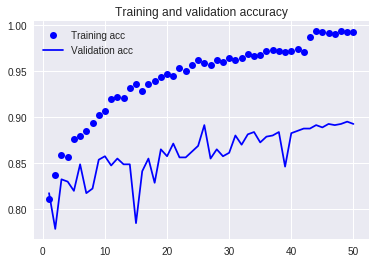

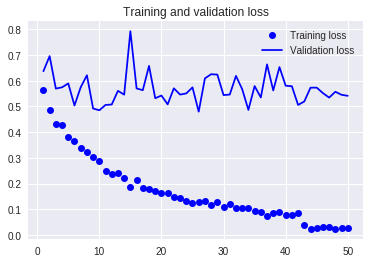

In [106]:
# Visualizing Loss and Accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [107]:
# Evaluating on Test set
model.evaluate_generator(test_generator)

[0.49597531195470845, 0.9019283746556473]

In [108]:
test_img_path = os.path.join(test_dir,'3')
test_img_path = os.path.join(test_img_path,os.listdir(test_img_path)[2])
print(test_img_path)

Dataset_Aug/test/3/102.jpg


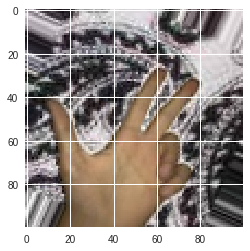

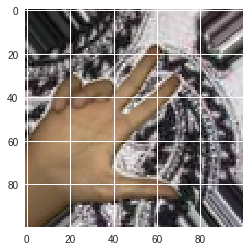

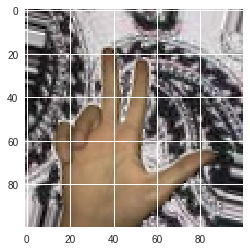

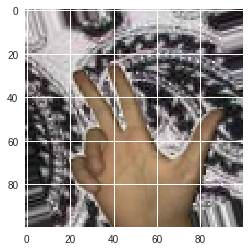

In [109]:
img = image.load_img(test_img_path,target_size = (100,100))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i=0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [110]:
np.argmax(model.predict(x))

3

In [0]:
model.save('SignLanguage_90_aug.h5')

In [0]:
# Loading model for visualizing convnet filters and intermediate activations
model = models.load_model('SignLanguage_84_aug.h5')

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)             0         
__________

In [88]:
img_path = 'Dataset_Aug/test/1/112.jpg'

img = image.load_img(img_path, target_size = (100,100))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 100, 100, 3)


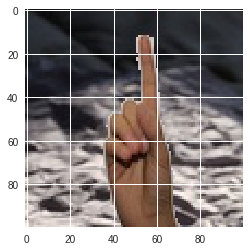

In [89]:
plt.imshow(img_tensor[0])

In [0]:
layers_output = [layer.output for layer in model.layers[:6]]
activation_model = models.Model(inputs=model.input, outputs=layers_output)

In [91]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 98, 98, 32)


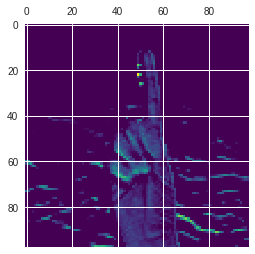

In [92]:
plt.matshow(first_layer_activation[0,:,:,17], cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


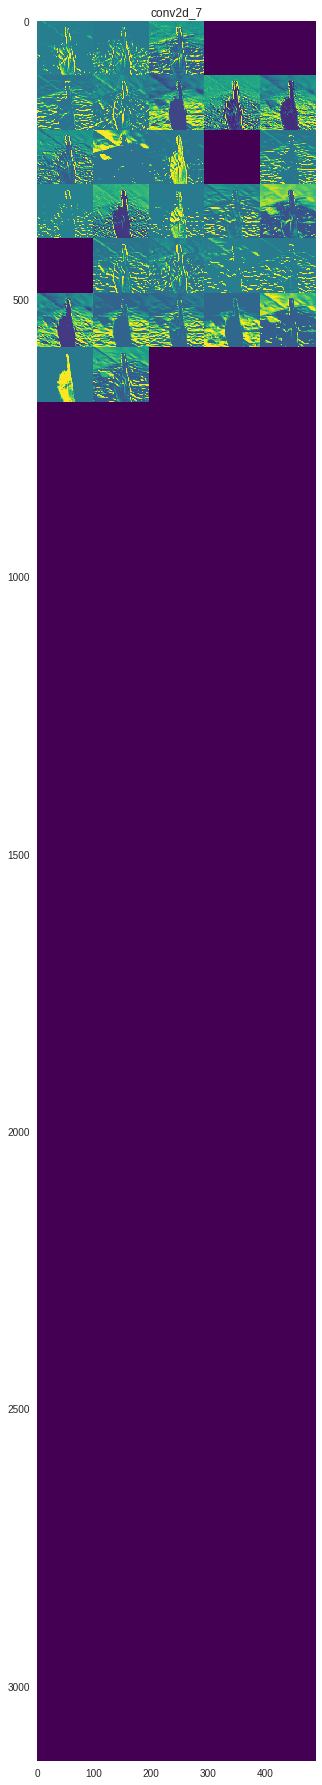

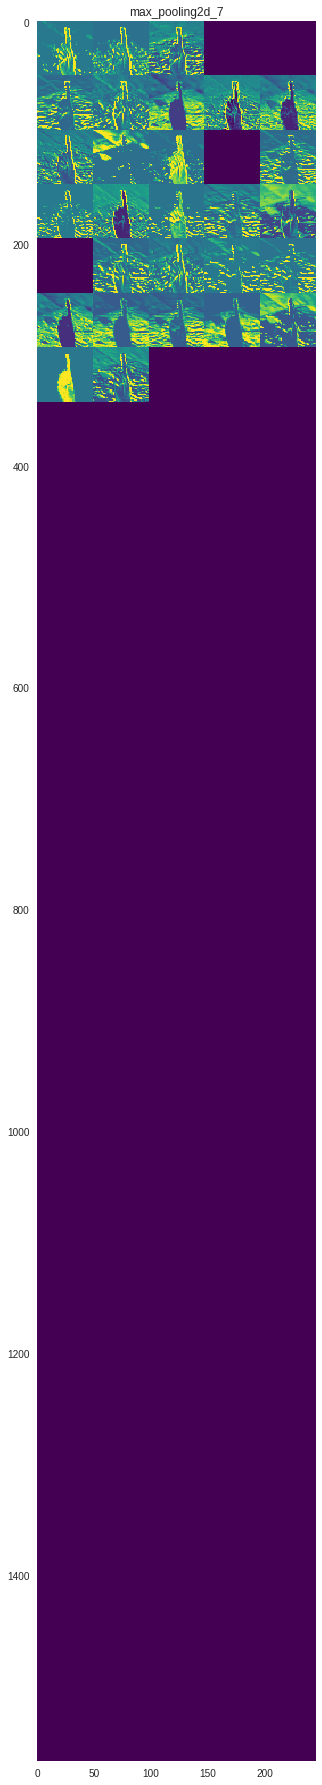

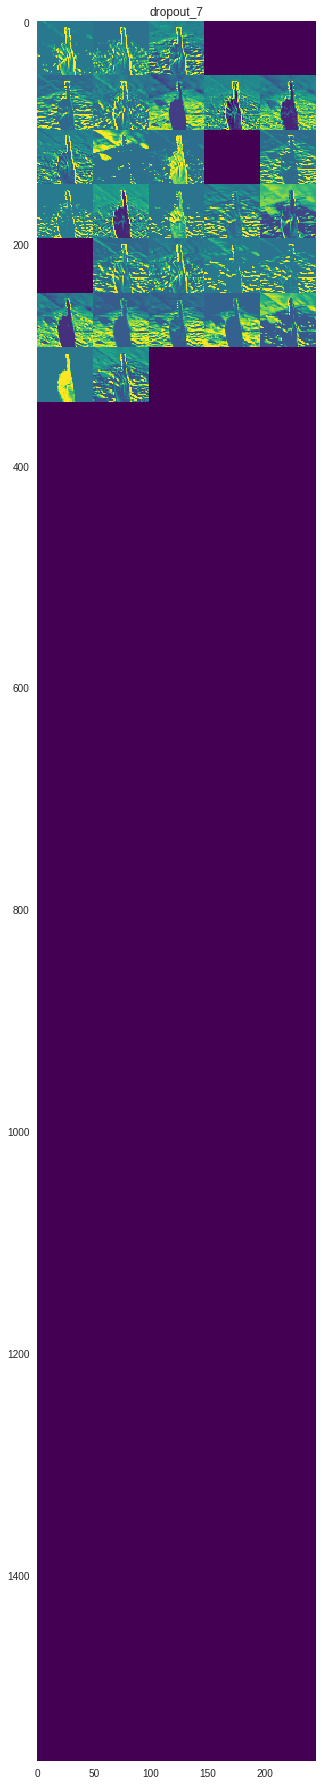

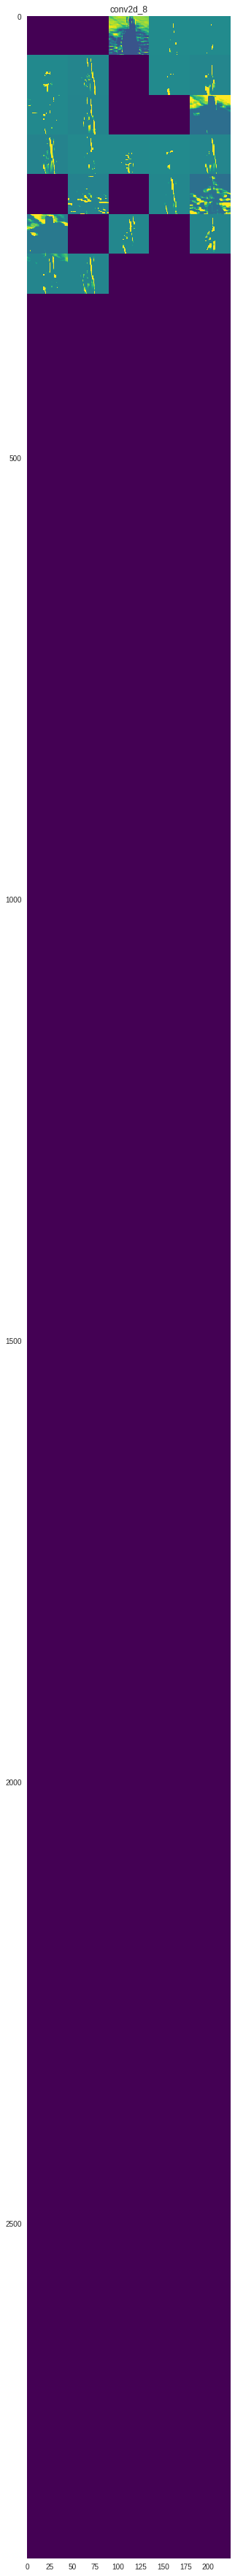

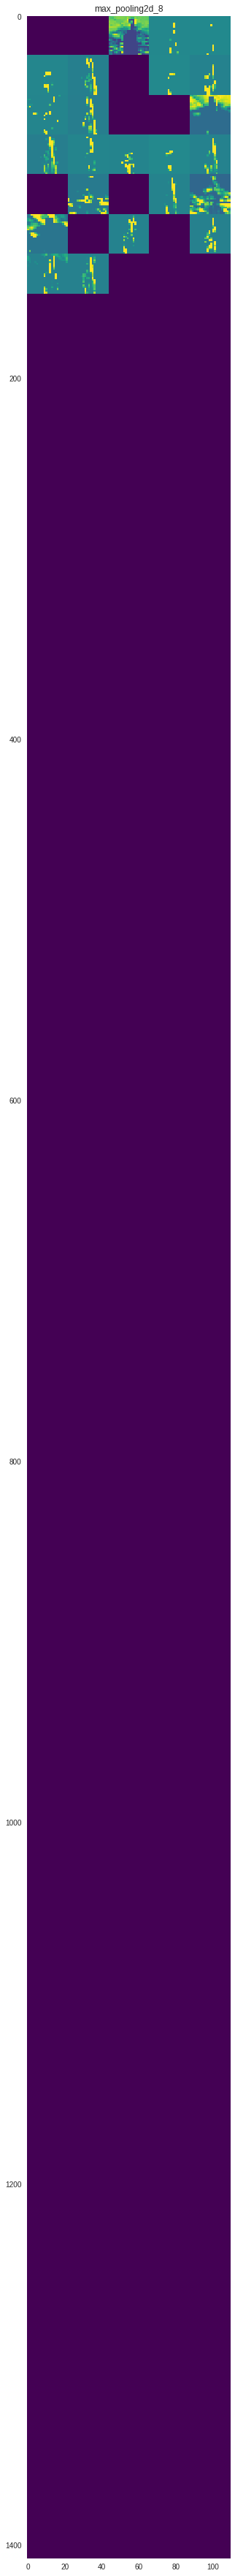

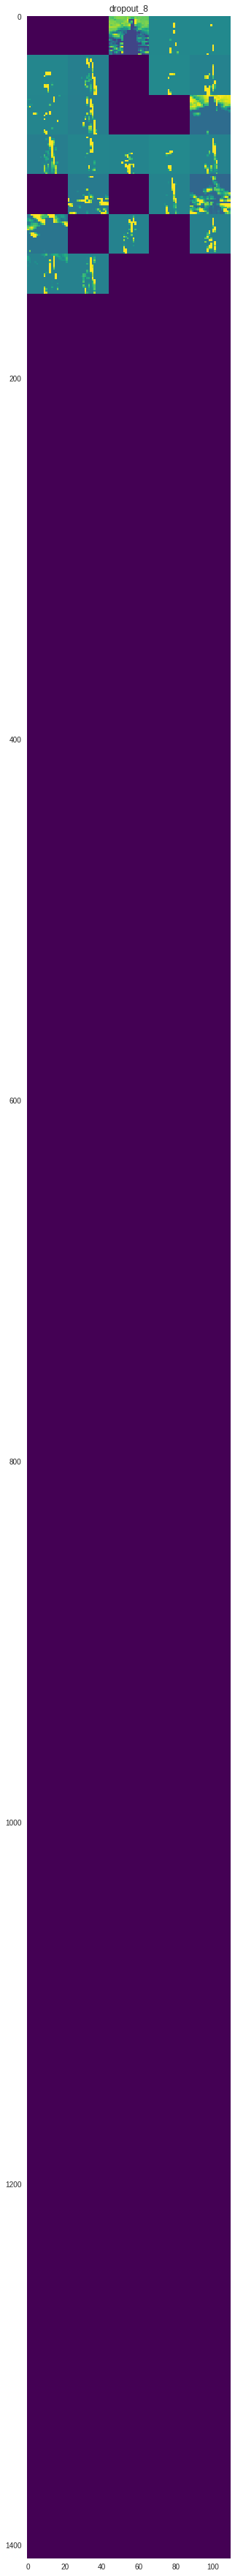

In [93]:
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

images_per_row =5

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
#     print(n_features)
    n_cols = n_features
    display_grid = np.zeros((size*n_cols, images_per_row*size))
#     print("grid shape:", display_grid.shape)
    for col in range(n_cols):
        for row in range(images_per_row):
#             print(row,col,images_per_row)
            if col*images_per_row + row >=32:
                continue
            channel_image = layer_activation[0,:,:,col*images_per_row + row ]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image +=128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[col*size:(col+1)*size, row*size: (row+1)*size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.savefig("{}.png".format(layer_name))

In [0]:
# # Visualizing convnet filters using gradient ascent
# from keras import backend as K

# layer_name = 'conv2d_5'
# filter_index = 0

# layer_output = model.get_layer(layer_name).output
# loss = K.mean(layer_output[:,:,:,filter_index]) 

In [0]:
grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

In [0]:
iterate = K.function([model.input], [loss,grads])
loss_value, grads_value = iterate([np.zeros((1,100,100,3))])

input_image= np.random.random((1,100,100,3)) *20 +128

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_image])
    input_image += grads_value * step

depreprocessed_image = deprocess_image(input_image)
print(depreprocessed_image.shape)
plt.imshow(depreprocessed_image[0])

In [0]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x+= 0.5
    x = np.clip(x,0,1)
    
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

In [0]:
def generate_pattern(layer_name, filter_index, size= 100):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index]) 
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    iterate = K.function([model.input], [loss,grads])
    loss_value, grads_value = iterate([np.zeros((1,100,100,3))])

    input_image= np.random.random((1,100,100,3)) *20 +128
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_image])
        input_image += grads_value * step
        
    img = input_image[0]
    return deprocess_image(img)

In [0]:
plt.imshow(generate_pattern('dropout_4',10))

In [0]:
# layer_name = 'conv2d_5'
# size = 100
# margin = 5

# results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

# for i in range(5):
#     for j in range(5):
#         filter_img = generate_pattern(layer_name,i+(j*8),size=size)
        
#         horizontal_start = i * size + i * margin
#         horizontal_end = horizontal_start + size
#         vertical_start = j * size + j * margin
#         vertical_end = vertical_start + size
#         results[horizontal_start: horizontal_end,
#                 vertical_start: vertical_end, :] = filter_img
# plt.figure(figsize = (20,20))
# plt.imshow(results)
# plt.savefig("filter-{}.png".format(layer_name))